# Workbench for analysis of the sinuosity of stream channels using shapefiles of channel centrelines

## import the data and setup the workspace and dataframes for subsequent analysis

In [1]:
from sinuutils import readshapestopandas

riverid = 6 # id of channel being analysed (CM_riverid)
#channelname = 'sinuosity_shapefiles/sin_CM5_no2012.shp'
channelname = '../sinuosity_shapefiles/sin_CM%d.shp' % riverid # define channel to be analysed
yearrivers = readshapestopandas(channelname)
# in yearrivers shapeid from readshapestopandas is the year that the profile was drawn


In [3]:
# import shapefile which contains the valley slopes for different years

valleyslope = '../sinuosity_shapefiles/valley_slope_prof_wgs84.shp'

direct_profiles = readshapestopandas(valleyslope)

# in this shapefile, the 'shapeid' is not a year but the id of the channel
# call the correct channel id using riverid

direct_profile = None
for shapeid, d in direct_profiles:
    if shapeid == riverid:
        direct_profile = d

# direct_profile  # uncomment out to see dataset

### plot profile for chosen channel in space relative to position of channel head

Text(0, 0.5, 'y position [m]')

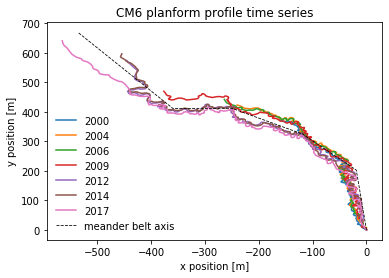

In [4]:
%matplotlib inline 
from matplotlib import pyplot as plt

for year, df in yearrivers:
    plt.plot(df.x, df.y, label='%d' % year)
    
plt.plot(direct_profile.x, direct_profile.y, color='k',linestyle='--',linewidth=0.8, label='meander belt axis')
#plt.axis('equal')
plt.legend(loc='lower left',frameon=False)  
plt.title('CM%d planform profile time series' % riverid)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')

## warp channel profile so that the meander belt axis behaves as the x-axis, meaning that sinuosity can be calculated relative to this only (simplifying code)

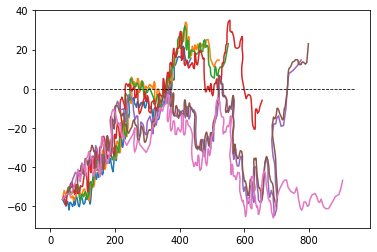

In [6]:
from sinuutils import transaxis
from sinuutils import warptodirect
import numpy as np
    
for year, df in yearrivers:
    straightenedx, straightenedy, cwtx, cwty, r0,r1 = warptodirect(direct_profile, df)
    plt.plot(straightenedx, straightenedy, label="%d" % year)
    
transax = np.linspace(0,r1,10)
transay = np.zeros((10,), dtype=int)
    
plt.plot(transax, transay, color='k', linestyle='--', linewidth=0.8)
#plt.legend(loc='lower left')


## calculate windowed sinuosity of the river channel where windows are not regularised ie depend only on the length of each digitised centre-line segment in the shapefile

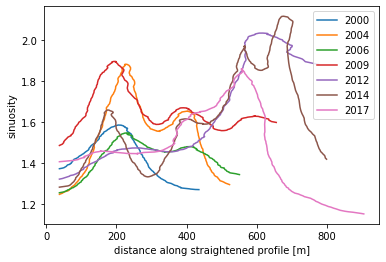

In [7]:
from sinuutils import windowed_sinuosity

# calculate windowed sinuosity for each given year
for year, df in yearrivers:
    wxs, awsin = windowed_sinuosity(df)
    plt.plot(df.straightenedx,df.windowedsin, label='%d' %year)
    
plt.xlabel('distance along straightened profile [m]')
plt.ylabel('sinuosity')
plt.legend()

In [8]:
#yearrivers # uncomment to see full dataframe

## resample the channel profiles at metre-resolution so that distance along reach consistent in the channel profiles

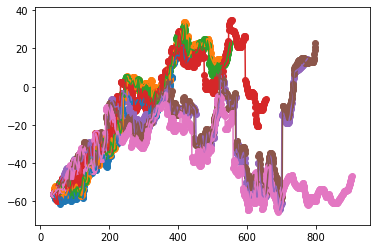

In [9]:
from sinuutils import metre_interp
import pandas as pd

yearrivers_interp = [ ]
for year, df in yearrivers:
    xvals, yinterp = metre_interp(df.straightenedx, df.straightenedy)
    df2 = pd.DataFrame({"chan_xvals":xvals, "chan_yinterp":yinterp})
    vx2 = (df2.chan_xvals - df2.chan_xvals.shift()).fillna(0)
    vy2 = (df2.chan_yinterp - df2.chan_yinterp.shift()).fillna(0)
    df2["straightenedsegleng"] = np.sqrt(vx2**2 + vy2**2)
    yearrivers_interp.append((year, df2))
     
    #plt.plot(df.straightenedx, df.straightenedy, label="%d" % year)
for year, df2 in yearrivers_interp:
    plt.plot(df2.chan_xvals, df2.chan_yinterp)
    plt.scatter(df2.chan_xvals, df2.chan_yinterp) 

In [8]:
#yearrivers_interp # uncomment to see full dataframe

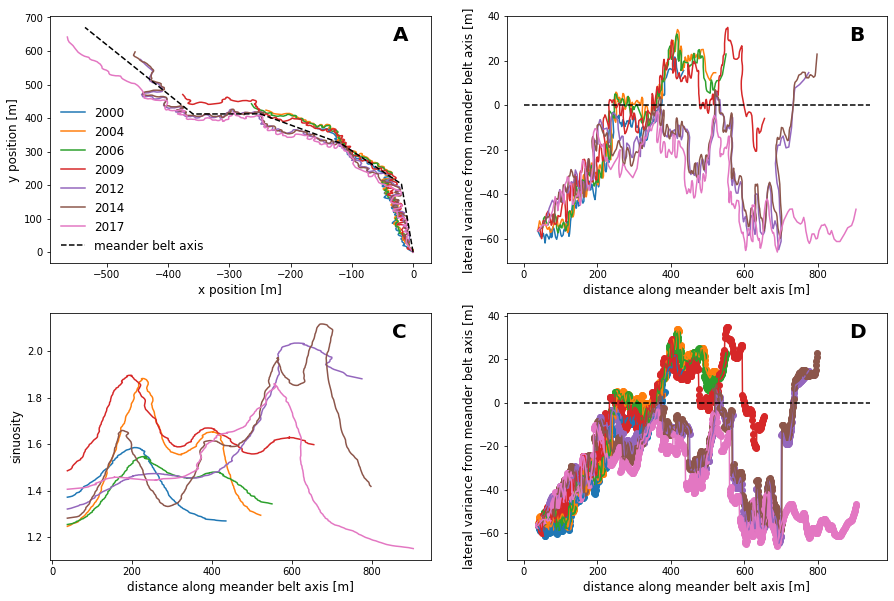

In [43]:
import string

# create figure with subplots showing full evolution of the data during processing
figp, axp = plt.subplots(2,2, figsize=(15,10))
#figp.suptitle('CM%d planform profile time series processing' % riverid, fontsize = 20, fontweight='bold')


# top left
for year, df in yearrivers:
    axp[0,0].plot(df.x, df.y, label='%d' % year)
    
axp[0,0].plot(direct_profile.x, direct_profile.y, color='k',linestyle='--',linewidth=1.5, label='meander belt axis')
axp[0,0].legend(loc='lower left',frameon=False, fontsize=12)  
#axp[0,0].set_title('Raw Data', fontsize=14)
axp[0,0].set_xlabel('x position [m]',fontsize=12)
axp[0,0].set_ylabel('y position [m]',fontsize=12)
#axp[0,0].text(-10, 620, 'A',fontsize='20', fontweight='bold')

# top right
for year, df in yearrivers:
    straightenedx, straightenedy, cwtx, cwty, r0,r1 = warptodirect(direct_profile, df)
    axp[0,1].plot(straightenedx, straightenedy, label="%d" % year)
    
axp[0,1].plot(transax, transay, color='k', linestyle='--', linewidth=1.5)
#axp[0,1].set_title('Straightened X Axis', fontsize=14)
axp[0,1].set_xlabel('distance along meander belt axis [m]',fontsize=12)
axp[0,1].set_ylabel('lateral variance from meander belt axis [m]',fontsize=12)
#axp[0,1].text(920, 30, 'B',fontsize='20', fontweight='bold')

# bottom left
for year, df in yearrivers:
    wxs, awsin = windowed_sinuosity(df)
    axp[1,0].plot(df.straightenedx,df.windowedsin, label='%d' %year)

#axp[1,0].set_title('windowed sinuosity not normalised to length', fontsize=14)
axp[1,0].set_xlabel('distance along meander belt axis [m]',fontsize=12)
axp[1,0].set_ylabel('sinuosity',fontsize=12)
#axp[1,0].text(880, 2.1, 'C',fontsize='20', fontweight='bold')

# bottom right
for year, df2 in yearrivers_interp:
    axp[1,1].plot(df2.chan_xvals, df2.chan_yinterp)
    axp[1,1].scatter(df2.chan_xvals, df2.chan_yinterp)

axp[1,1].plot(transax, transay, color='k', linestyle='--', linewidth=1.5)
#axp[1,1].set_title('channel profiles resampled at metre-resolution', fontsize=14)
axp[1,1].set_xlabel('distance along meander belt axis [m]',fontsize=12)
axp[1,1].set_ylabel('lateral variance from meander belt axis [m]',fontsize=12)
#axp[1,1].text(890, 30, 'D',fontsize='20', fontweight='bold')

axp = axp.flat
for n, ax in enumerate(axp):    
    ax.text(0.9, 0.9, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.savefig('../images/sinuosity_data_processing_workflow_pub.png')


## calculate windowed sinuosity of the river channel where window length can now be expressed in metres rather than arbitrary lengths

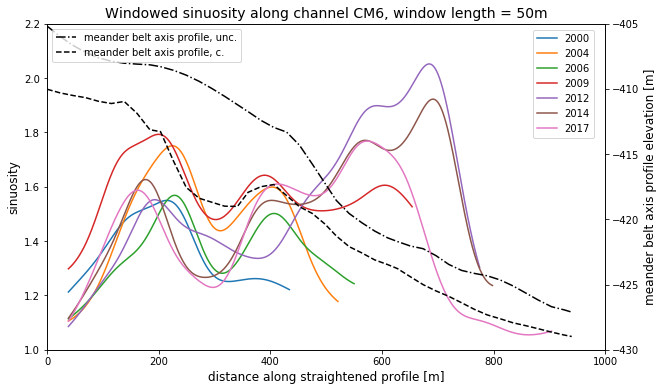

In [9]:
#from sinuutils import makeweightseries
from sinuutils import windowed_sin_interp
centreweightlength = 50 # width of window in metres: change as appropriate

fig = plt.figure(figsize = (10,6))
ax1 = plt.axes()

for year, df2 in yearrivers_interp:
    wxs, awsin = windowed_sin_interp(df2, centreweightlength)
    ax1.plot(df2.chan_xvals,df2.windowedsin, label='%d' %year)

plt.xlim(0, 1000)
plt.ylim(1, 2.2)
plt.xlabel('distance along straightened profile [m]', fontsize=12)
plt.ylabel('sinuosity', fontsize=12)
plt.title('Windowed sinuosity along channel CM%d, window length = %dm' %(riverid,centreweightlength), fontsize=14)

# read in meander belt axes profiles and plot on right hand axes

# dataframe for meander belt axis slopes
df3 = pd.read_csv('../channel_slope_profs/corrected_bath_meander_belt_axes.csv', header=0)

ax2 = ax1.twinx()

for n in range(riverid,riverid+1):
    MBA = df3[df3.prof_id == n]
    ax2.plot(MBA.cds2d, MBA.bathymetry, 'k-.', label='meander belt axis profile, unc.')
    ax2.plot(MBA.cds2d, MBA.bathymetry_new, 'k--', label='meander belt axis profile, c.')

plt.xlim(0, 1000)
plt.ylim(-430, -405)
ax2.set_ylabel('meander belt axis profile elevation [m]', color='k', fontsize=12)
ax2.tick_params('y', colors='k')
ax1.legend(loc=[0.87, 0.65],fontsize=10)
ax2.legend(loc = 'upper left', fontsize=10)

plt.savefig('sinuosity_CM%d_bath_corr.png' %riverid)
plt.savefig('sinuosity_CM%d_bath_corr.svg' %riverid)

### demonstrate the sensitivity of channel sinuosity to different window lengths

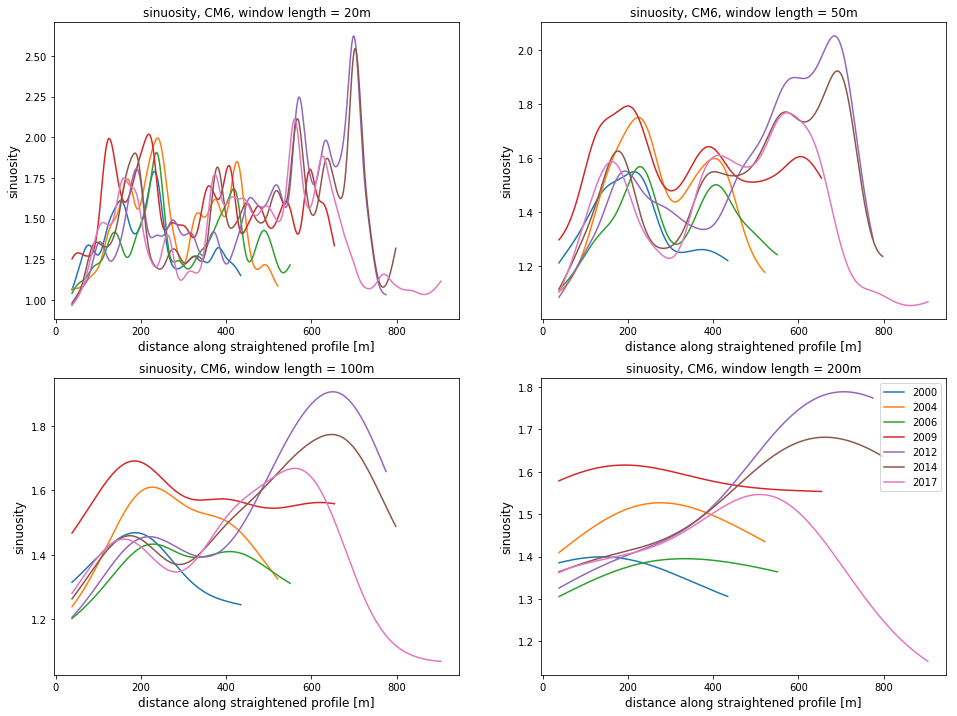

In [10]:
# plot channel sinuosity along length with different window lengths 

fig = plt.figure(figsize = (16,12))

window_tests = [20,50,100,200]

for n in range(0,4):
    ax = fig.add_subplot(2, 2, n+1)
    for year, df2 in yearrivers_interp:
        wxs, awsin = windowed_sin_interp(df2, window_tests[n])
        plt.plot(df2.chan_xvals,df2.windowedsin, label='%d' %year)
        plt.title('sinuosity, CM%d, window length = %dm' %(riverid, window_tests[n]))
        plt.xlabel('distance along straightened profile [m]', fontsize=12)
        plt.ylabel('sinuosity', fontsize=12)

plt.legend(loc = 'upper right')
plt.savefig('windows_CM%d.png' %riverid)